In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import surprise

from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import cross_validate, KFold
from sklearn import metrics

from collections import defaultdict

from calldata.surprise_dataset import SupriseMovielensDataset, SurpriseDataset

## Data Load

In [2]:
MovieLens = SupriseMovielensDataset('./dataset/ml-100k/u.data')

In [3]:
MovieLens.df.head()

,uid,iid,rate,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


## Precision and Recall

In [4]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

## DCG and NDCG

input `r` 은 `예측값(est)` 의 `rank` 순으로 정렬된 실제 `rating` 이다.

In [5]:
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
    return 0.

def ndcg_at_k(r, k):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k) / dcg_max

### example

argsort 를 이용하여 rating 의 rank 찾기

In [6]:
array = np.array([4,2,7,1])
array

array([4, 2, 7, 1])

In [7]:
temp = array.argsort()
temp

array([3, 1, 0, 2], dtype=int64)

In [8]:
array[temp] # 랭크순으로 정렬

array([1, 2, 4, 7])

예시)

<img src="https://user-images.githubusercontent.com/29483429/69978590-13260280-1570-11ea-9a2a-269d5681a004.png">

In [9]:
real = np.array([2, 1, 4, 5])

est = np.array([3.23, 2.13, 3.12, 4.58])

real[np.argsort(-est)] # -est (음수처리를 통해 역순정렬)

array([5, 2, 4, 1])

In [10]:
dcg_at_k(real[np.argsort(-est)], 4)

10.023719014285831

In [11]:
ndcg_at_k(real[np.argsort(-est)], 4)

0.9314114356940674

## 모든 유저에 적용

In [12]:
def ndcg_at_k_all(predictions, k):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append([est, true_r])
    
    sum_ndcg = 0.
    
    # iterate over users
    for uid in user_est_true.keys():
        tmp = np.array(user_est_true[uid])
        r = tmp[:, 1][np.argsort(-tmp[:, 0])]
        sum_ndcg += ndcg_at_k(r, k)
    
    return sum_ndcg / len(user_est_true.keys())

## KFold 를 이용한 cross validation

In [13]:
data = MovieLens.data

In [14]:
kf = KFold(n_splits=5)

In [15]:
KFold??

In [16]:
def train_with_Kfold(algo, data, k=5, verbose=True):
    
    kf = KFold(n_splits=k,)
    
    history = pd.DataFrame(columns=['precision','recall', 'f1', 'NDCG'])
    
    i = 0
    for trainset, testset in kf.split(data):
        # algo 는 fit의 인자로 trainset 객체를 받고,
        algo.fit(trainset)
        predictions = algo.test(testset) # test의 인자로 튜플의 list 를 받는다.
        precisions, recalls = precision_recall_at_k(predictions, k=15, threshold=4)

        P = sum(rec for rec in precisions.values()) / len(precisions)
        R = sum(rec for rec in recalls.values()) / len(recalls)
        F1 = (2 * P * R) / (P + R)
        # NDCG 의 top k rank 는 k=5 사용
        NDCG = ndcg_at_k_all(predictions, k=5)
        
        history.loc[i]=[P, R, F1, NDCG]
        
        if verbose:
            print(f"FOLD: {i}")
            print("precision: ", P)
            print("recall: ",R)
            print("f1: ",F1)
            print("NDCG: ",NDCG)
            print("------")
        
        i +=1
    
    return history

## 알고리즘 별 성능비교

In [17]:
algo = SVD(n_factors=100, n_epochs=20, biased=False, lr_all=0.005, reg_all=0)
SVD_history = train_with_Kfold(algo, data, 5, False)

In [18]:
sim_options = {'name':'cosine', 'user_based': True}
algo = KNNBasic(k=40, min_k=1, sim_options=sim_options, verbose=False)
KNNBasic_history = train_with_Kfold(algo, data, 5, False)

In [19]:
sim_options = {'name':'cosine', 'user_based': True}
algo = KNNWithMeans(k=40, min_k=1, sim_options=sim_options, verbose=False)
KNNWithMeans_history = train_with_Kfold(algo, data, 5, False)

In [20]:
sim_options = {'name':'cosine', 'user_based': True}
algo = KNNWithZScore(k=40, min_k=1, sim_options=sim_options, verbose=False)
KNNWithZScore_hitstory = train_with_Kfold(algo, data, 5, False)

In [21]:
print(SVD_history)
print(KNNBasic_history)
print(KNNWithMeans_history)
print(KNNWithZScore_hitstory)

   precision    recall        f1      NDCG
0   0.877847  0.280905  0.425615  0.896142
1   0.880364  0.293148  0.439837  0.894144
2   0.873281  0.290367  0.435823  0.894444
3   0.881308  0.285528  0.431317  0.893461
4   0.873299  0.282878  0.427334  0.891031
   precision    recall        f1      NDCG
0   0.804026  0.378694  0.514880  0.898549
1   0.819005  0.373382  0.512923  0.894870
2   0.806252  0.358769  0.496571  0.893766
3   0.829481  0.356303  0.498483  0.894921
4   0.820927  0.371762  0.511767  0.894496
   precision    recall        f1      NDCG
0   0.881149  0.313404  0.462358  0.889192
1   0.882992  0.316697  0.466189  0.890256
2   0.888298  0.320430  0.470970  0.893145
3   0.901488  0.314426  0.466236  0.894765
4   0.889475  0.319987  0.470657  0.891162
   precision    recall        f1      NDCG
0   0.888771  0.319379  0.469900  0.890270
1   0.874304  0.328155  0.477201  0.892507
2   0.884954  0.326193  0.476682  0.895283
3   0.890451  0.332938  0.484662  0.896088
4   0.88171

# KNN With Means 의 K를 결정해보자.

K를 5씩 늘려가며 매번 5번의 Fold 를 진행 (5번 Fold 의 평균값을 사용)

## multiprocessing 모듈로 병렬화

In [22]:
import multiprocessing
from multiprocessing import Process, Pool, cpu_count
from functools import partial
from multiprocessing_files import multi_kfold

In [23]:
print("Number of cpu : ", cpu_count())

Number of cpu :  16


`Windows 10`, `Jupyter notebook`에서는 `multiprocessing` 모듈이 정상 작동 하지 않는다. (아래 링크참조)

https://stackoverflow.com/questions/45719956/python-multiprocessing-in-jupyter-on-windows-attributeerror-cant-get-attribut


해결책:

    병렬 실행시킬 함수를 별도의 `.py` 파일로 저장하고, import 하면 된다.

```py
Signature: multi_kfold.work(data, k)
Docstring: <no docstring>
Source:   
def work(data, k):

    history = {}

    p_history=[]
    r_history=[]
    f1_history=[]
    ndcg_history=[]

    sim_options = {'name':'cosine', 'user_based': True}
    algo = KNNWithMeans(k=k, min_k=1, sim_options=sim_options, verbose=False)
    KNNWithMeans_history = train_with_Kfold(algo, data, 5, False)
    
    p_history.append(KNNWithMeans_history.mean()[0])
    r_history.append(KNNWithMeans_history.mean()[1])
    f1_history.append(KNNWithMeans_history.mean()[2])
    ndcg_history.append(KNNWithMeans_history.mean()[3])

    history[str(k)] = {
        "precision" : p_history,
        "recall"    : r_history,
        "f1"        : f1_history,
        "ndcg"      : ndcg_history
    }

    return history
File:      c:\users\21jun\develop\rsdataset\multiprocessing_files\multi_kfold.py
Type:      function
```

In [24]:
func = partial(multi_kfold.work, data)

In [31]:
p = Pool(processes=16)
result = p.map(func, [i for i in range(20, 180, 5)])
p.close()

In [32]:
p_history=[]
r_history=[]
f1_history=[]
ndcg_history=[]

for i in range(32):
    p_history.append(result[i][list(result[i])[0]]['precision'][0])
    r_history.append(result[i][list(result[i])[0]]['recall'][0])
    f1_history.append(result[i][list(result[i])[0]]['f1'][0])
    ndcg_history.append(result[i][list(result[i])[0]]['ndcg'][0])

# K 결정하기 (KNN WITH MEAN)

## Precision

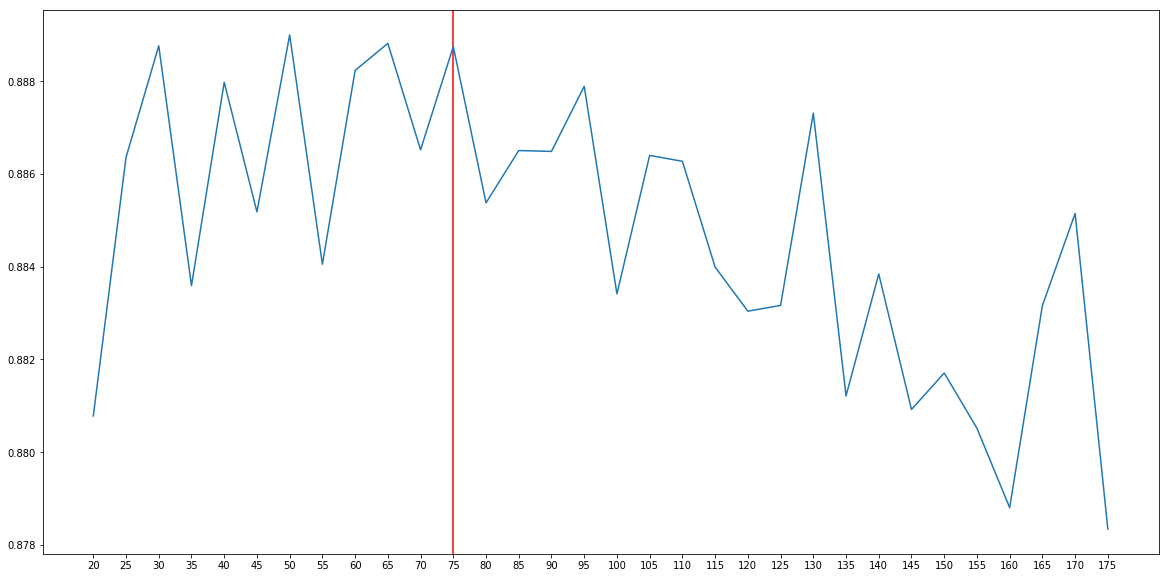

In [33]:
plt.figure(figsize=(20, 10))
plt.axvline(x=11, color='red')
plt.xticks(list(range(32)), range(20, 180, 5))
plt.plot(p_history)

## Recall

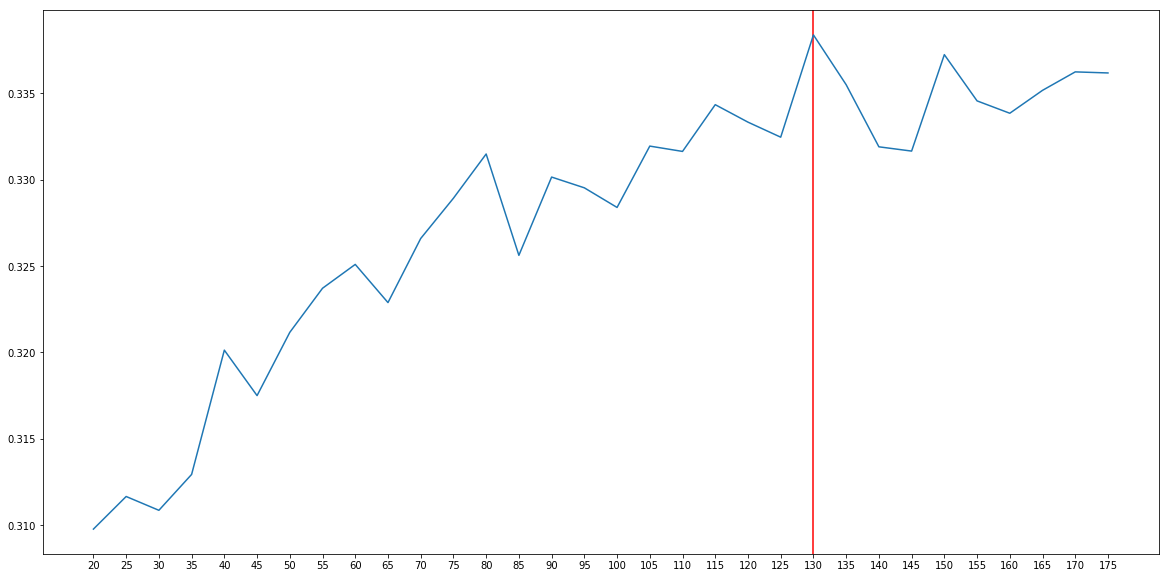

In [39]:
plt.figure(figsize=(20, 10))
plt.axvline(x=22, color='red')
plt.xticks(list(range(32)), range(20, 180, 5))
plt.plot(r_history)

## F1

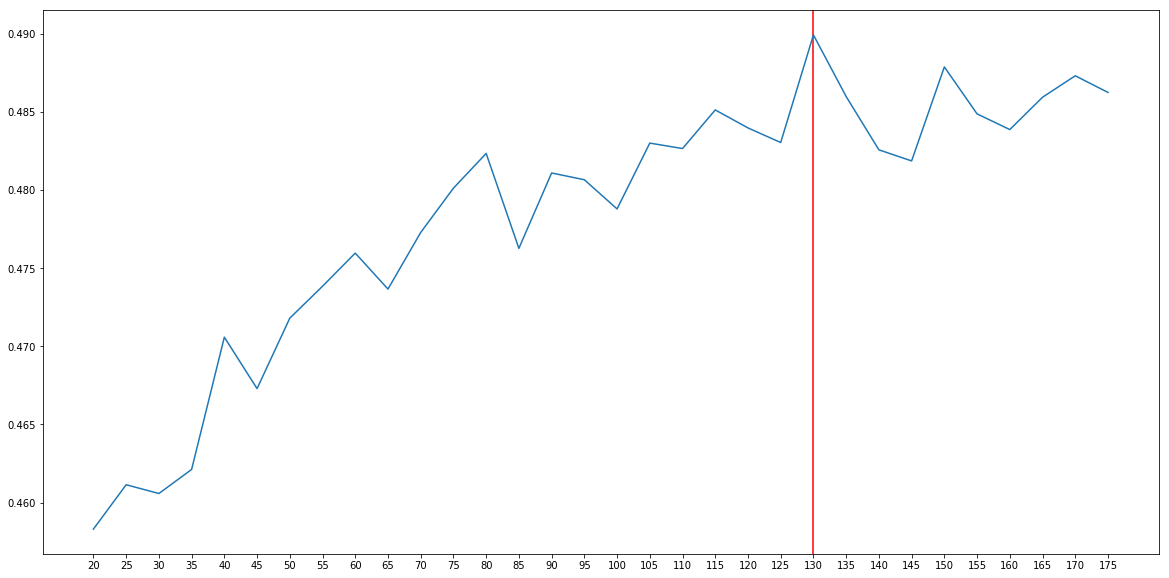

In [38]:
plt.figure(figsize=(20, 10))
plt.axvline(x=22, color='red')
plt.xticks(list(range(32)), range(20, 180, 5))
plt.plot(f1_history)

## NDCG

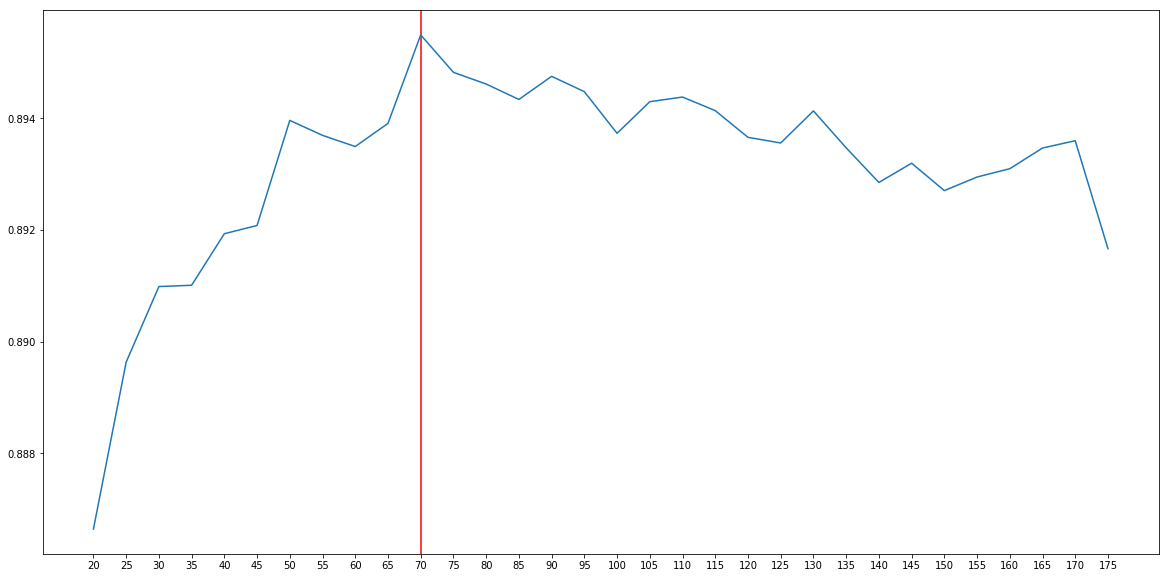

In [37]:
plt.figure(figsize=(20, 10))
plt.axvline(x=10, color='red')
plt.xticks(list(range(32)), range(20, 180, 5))
plt.plot(ndcg_history)

# Conclusion

Recall 과 F1 은 `K:130` 일때,

Precision 과 NDCG는 각각 `K:75` `K:70` 일때 가장 좋은 성능을 냈다.

